# Bulldozer Sales Price Prediction - Time-series Regression Project

In the following time-series project, a dataset of more than 412,000 bulldozers has been processed and modeled, employing Random Forest Regressor to predict their sale prices.

The data is sourced from the [Kaggle Bluebook for Bulldozers competition](https://www.kaggle.com/c/bluebook-for-bulldozers/overview).

This project includes the following sections:

* Data understanding and exploration
* Parsing dates
* Feature engineering
* Data processing and imputing
* Modelling
* Hyperparameter tuning
* Model evaluation
* Feature importance

## 1. Problem Definition

For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## 2. Data

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you can you it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

## 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

## 4. Features

Features are different parts of the data. During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this, is to create a **data dictionary**.

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means. You can [download this file directly from the Kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) or view it on Google Sheets.

With all of this being known, let's get started! 

First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.

### Importing the data and preparing it for modelling

In [1]:
# Import data analysis tools 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Now we've got our tools for data analysis ready, we can import the data and start to explore it.

For this project, we've [downloaded the data from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data) and stored it under the file path `"../data/"`.

In [2]:
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)

In [47]:
# No parse_dates... check dtype of "saledate"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [19]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [20]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [21]:
df.head() # ... hides several columns

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


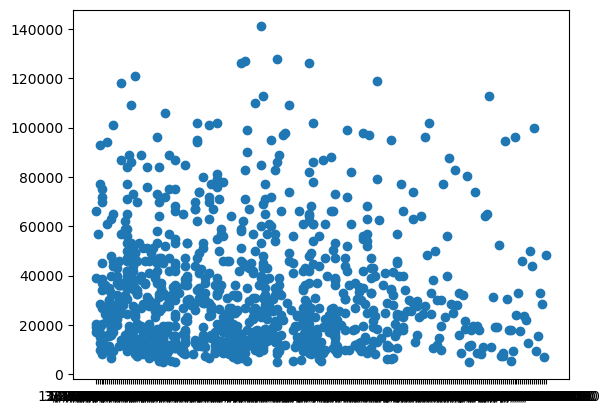

In [22]:
# Plotting the first 1000 rows of sale prices
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

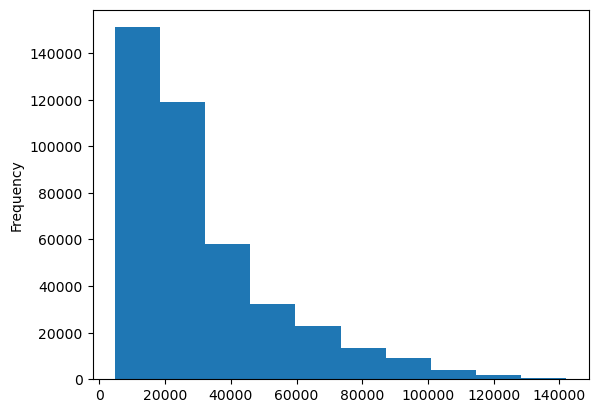

In [23]:
df.SalePrice.plot.hist();

In [24]:
df.saledate

0         11/16/2006 0:00
1          3/26/2004 0:00
2          2/26/2004 0:00
3          5/19/2011 0:00
4          7/23/2009 0:00
               ...       
412693      3/7/2012 0:00
412694     1/28/2012 0:00
412695     1/28/2012 0:00
412696      3/7/2012 0:00
412697     1/28/2012 0:00
Name: saledate, Length: 412698, dtype: object

In [25]:
df.saledate.dtype

dtype('O')

### Parsing dates
When working with time series data, it's a good idea to make sure any date data is the format of a [datetime object](https://docs.python.org/3/library/datetime.html) (a Python data type which encodes specific information about dates).

In [39]:
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])

In [27]:
# With parse_dates... check dtype of "saledate"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [28]:
df.saledate.dtype

dtype('<M8[ns]')

In [86]:
df.saledate
# Note that 11/16/2006 0:00 format is converted to 2006-11-16

# '<M8[ns]' is the same as datetime64[ns]

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

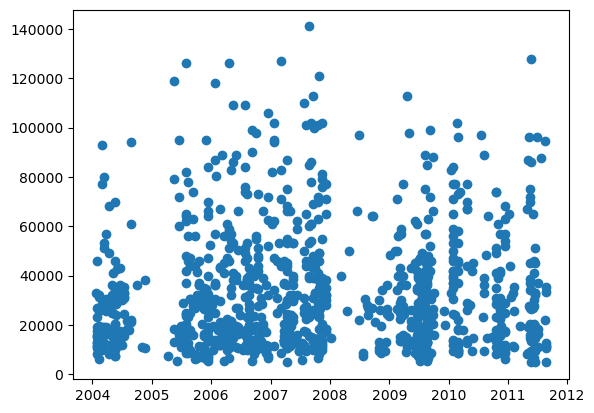

In [30]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [31]:
df.head() # ... hides several columns

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df.head().T # Now we can see all columns

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [33]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

As we're working on a time series problem and trying to predict future examples given past examples, it makes sense to sort our data by date.

In [40]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [35]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


### Make a copy of the original DataFrame

Since we're going to be manipulating the data, we'll make a copy of the original DataFrame and perform our changes there.

This will keep the original DataFrame intact if we need it again.

In [7]:
# Make a copy of the original DataFrame to perform edits on
df_tmp = df.copy() # Includes the changes up until now (like sorting the dataframe based on sale date)

In [9]:
df_tmp.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Add datetime parameters for saledate column

Why?

So we can enrich our dataset with as much information as possible.

Because we imported the data using `read_csv()` and we asked pandas to parse the dates using `parase_dates=["saledate"]`, we can now access the [different datetime attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) of the `saledate` column.

In [38]:
df_tmp[:1] # slicing the first row

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN


In [39]:
df_tmp[:1].saledate

205615   1989-01-17
Name: saledate, dtype: datetime64[ns]

In [40]:
df_tmp[:1].saledate.dt.year

205615    1989
Name: saledate, dtype: int64

In [41]:
df_tmp[:1].saledate.dt.month

205615    1
Name: saledate, dtype: int64

In [42]:
df_tmp[:1].saledate.dt.day

205615    17
Name: saledate, dtype: int64

In [42]:
# Add datetime parameters for saledate
df_tmp["saleYear"] = df_tmp.saledate.dt.year # Each line adds a column to the dataframe
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayofweek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayofyear"] = df_tmp.saledate.dt.dayofyear

# Drop original saledate
df_tmp.drop("saledate", axis=1, inplace=True)

In [44]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [45]:
# Check the different values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

## 5. Modelling

We've explored our dataset a little as well as enriched it with some datetime attributes, now let's try to model.

Why model so early?

We know the evaluation metric we're heading towards. We could spend more time doing exploratory data analysis (EDA), finding more out about the data ourselves but what we'll do instead is use a machine learning model to help us do EDA.

Following the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), we find a [RandomForestRegressor()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn-ensemble-randomforestregressor) might be a good candidate.

In [11]:
# Check for missing categories and different datatypes
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

In [92]:
# Check for missing values
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

## Convert strings to categories

One way to help turn all of our data into numbers is to convert the columns with the string datatype into a category datatype.

To do this we can use the [pandas types API](https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality) which allows us to interact and manipulate the types of data.

In [52]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

True

In [51]:
variable=df_tmp.items()
variable

<generator object DataFrame.items at 0x000002381C3D7B50>

In [52]:
# These columns contain strings
for label, content in df_tmp.items(): # this loops over columns and their content
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [53]:
# If you're wondering what df.items() does, let's use a dictionary as an example
random_dict = {"key1": "hello", "key2": "world!"}

for key, value in random_dict.items():
    print(f"This is a key: {key}")
    print(f"This is a value: {value}")

This is a key: key1
This is a value: hello
This is a key: key2
This is a value: world!


In [43]:
# This will turn all of the string values into category values
for label, content in df_tmp.items(): # this loops over columns and their content
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered() 

In [14]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [56]:
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [15]:
# This turns the state column into integer
df_tmp.state.cat.codes # or pd.Categorical(df_tmp['state']).codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [97]:
state2 = df_tmp.state.cat.codes # Turning the state column into integer

In [98]:
state2.info()

<class 'pandas.core.series.Series'>
Int64Index: 412698 entries, 205615 to 409203
Series name: None
Non-Null Count   Dtype
--------------   -----
412698 non-null  int8 
dtypes: int8(1)
memory usage: 3.5 MB


In [99]:
bb=pd.Categorical(df_tmp['state']).codes
bb, bb.dtype

(array([43,  8,  8, ...,  4,  4,  4], dtype=int8), dtype('int8'))

All of our data is categorical and thus we can now turn the categories into numbers, however it's still missing values...

In [57]:
df_tmp.isnull().sum()/len(df_tmp) # or df_tmp.isna().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

In the format it's in, it's still good to be worked with, let's save it to file and reimport it so we can continue on.

### Save Processed Data

In [58]:
# Save preprocessed data
df_tmp.to_csv("data/bluebook-for-bulldozers/train_tmp.csv", index=False)

In [3]:
# Import preprocessed data
df_tmp = pd.read_csv("data/bluebook-for-bulldozers/train_tmp.csv", low_memory=False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


Excellent, our processed DataFrame has the columns we added to it but it still has missing values.

In [54]:
# Check missing values
df_tmp.isna().sum() # or df_tmp.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

## Fill missing values

From our experience with machine learning models, we know two things:
1. All of our data has to be numerical
2. There can't be any missing values

And as we've seen using `df_tmp.isna().sum()` our data still has plenty of missing values.

Let's fill them.

### First filling and turning categorical variables to numbers

We should fill the missing categorical cells and at the same time turning them into numbers.

In [74]:
# Check columns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [75]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(df_tmp[label].isna().sum(), label)

339028 UsageBand
0 fiModelDesc
0 fiBaseModel
140727 fiSecondaryDesc
354031 fiModelSeries
337882 fiModelDescriptor
216605 ProductSize
0 fiProductClassDesc
0 state
0 ProductGroup
0 ProductGroupDesc
305611 Drive_System
334 Enclosure
214983 Forks
331602 Pad_Type
259970 Ride_Control
331602 Stick
224691 Transmission
331602 Turbocharged
386715 Blade_Extension
386715 Blade_Width
386715 Enclosure_Type
386715 Engine_Horsepower
82565 Hydraulics
386715 Pushblock
305753 Ripper
386704 Scarifier
386715 Tip_Control
315060 Tire_Size
192019 Coupler
367724 Coupler_System
367823 Grouser_Tracks
367823 Hydraulics_Flow
310505 Track_Type
309782 Undercarriage_Pad_Width
310437 Stick_Length
310366 Thumb
310437 Pattern_Changer
310505 Grouser_Type
331986 Backhoe_Mounting
330823 Blade_Type
330821 Travel_Controls
341134 Differential_Type
341176 Steering_Controls


In [76]:
pd.Categorical(df_tmp['state'])

['Texas', 'Florida', 'Florida', 'Florida', 'Florida', ..., 'California', 'California', 'California', 'California', 'California']
Length: 412698
Categories (53, object): ['Alabama' < 'Alaska' < 'Arizona' < 'Arkansas' ... 'Washington DC' < 'West Virginia' < 'Wisconsin' < 'Wyoming']

In [77]:
pd.Categorical(df_tmp['state']).dtype

CategoricalDtype(categories=['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
                  'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
                  'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
                  'Kentucky', 'Louisiana', 'Maine', 'Maryland',
                  'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
                  'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
                  'New Jersey', 'New Mexico', 'New York', 'North Carolina',
                  'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
                  'Puerto Rico', 'Rhode Island', 'South Carolina',
                  'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah',
                  'Vermont', 'Virginia', 'Washington', 'Washington DC',
                  'West Virginia', 'Wisconsin', 'Wyoming'],
, ordered=True)

In [78]:
pd.Categorical(df_tmp['state']).codes # or df_tmp.state.cat.codes
# Turns categories into integer

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [79]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [80]:
pd.Categorical(df_tmp['UsageBand']).codes
# When Pandas converts categories into integer, assigns -1 to missing values.

array([-1, -1, -1, ..., -1, -1, -1], dtype=int8)

In [44]:
# Turn categorical variables into numbers and filling missing cells with 0
for label, content in df_tmp.items():
    # Check columns which aren't numeric
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to inidicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # We add the +1 because pandas encodes missing categories as -1
        # Below line does 3 jobs: 1. converts objects to categories, 2. converts categories
        # to numbers, 3. fills missing cells with 0 
        df_tmp[label] = pd.Categorical(content).codes+1 # or df_tmp[label] = df_tmp.label.cat.codes+1

Why add a binary column indicating whether the data was missing or not?

We can easily fill all of the missing numeric values in our dataset with the median. However, a numeric value may be missing for a reason. In other words, absence of evidence may be evidence of absence. Adding a binary column which indicates whether the value was missing or not helps to retain this information.

In [82]:
df_tmp['UsageBand'].head() # Now missing values are filled with 0

205615    0
274835    0
141296    0
212552    0
62755     0
Name: UsageBand, dtype: int8

In [83]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Columns: 101 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(44), float64(3), int16(4), int64(10), int8(40)
memory usage: 80.3 MB


### Filling numerical values

We're going to fill any column with missing values with the median of that column.

In [87]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls
saleYear
saleMonth
saleDay
saleDayofweek
saleDayofyear
UsageBand_is_missing
fiModelDesc_is_missing
fiBaseModel_is_missing
fiSecondaryDesc_is_missing
fiModelSeries_is_missing
fiModelDescriptor_is_missing
ProductSize_is_missing
fiProductClassDesc_is_missing
state_is_missing
ProductGroup_is_missing
ProductGroupDesc_is_missing
Drive_Syste

In [88]:
# Check for which numeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum()>0: # or if df_tmp[label].isna().sum()>0:
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [89]:
# Another way for finding the number of missing values in numerical columns
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(df_tmp[label].isna().sum(), label)

0 SalesID
0 SalePrice
0 MachineID
0 ModelID
0 datasource
20136 auctioneerID
0 YearMade
265194 MachineHoursCurrentMeter
0 UsageBand
0 fiModelDesc
0 fiBaseModel
0 fiSecondaryDesc
0 fiModelSeries
0 fiModelDescriptor
0 ProductSize
0 fiProductClassDesc
0 state
0 ProductGroup
0 ProductGroupDesc
0 Drive_System
0 Enclosure
0 Forks
0 Pad_Type
0 Ride_Control
0 Stick
0 Transmission
0 Turbocharged
0 Blade_Extension
0 Blade_Width
0 Enclosure_Type
0 Engine_Horsepower
0 Hydraulics
0 Pushblock
0 Ripper
0 Scarifier
0 Tip_Control
0 Tire_Size
0 Coupler
0 Coupler_System
0 Grouser_Tracks
0 Hydraulics_Flow
0 Track_Type
0 Undercarriage_Pad_Width
0 Stick_Length
0 Thumb
0 Pattern_Changer
0 Grouser_Type
0 Backhoe_Mounting
0 Blade_Type
0 Travel_Controls
0 Differential_Type
0 Steering_Controls
0 saleYear
0 saleMonth
0 saleDay
0 saleDayofweek
0 saleDayofyear
0 UsageBand_is_missing
0 fiModelDesc_is_missing
0 fiBaseModel_is_missing
0 fiSecondaryDesc_is_missing
0 fiModelSeries_is_missing
0 fiModelDescriptor_is_missin

### Splitting data into train/valid sets
**First we split the data into train and validation sets, then we fill the missing cells of two sets separately.** Because we should use the available data of train set to fill the missing cells of train set, and we should use the available data of validation set to fill the missing cells of validation set.

According to the [Kaggle data page](https://www.kaggle.com/c/bluebook-for-bulldozers/data), the validation set and test set are split according to dates.

This makes sense since we're working on a time series problem.

E.g. using past events to try and predict future events.

Knowing this, randomly splitting our data into train and test sets using something like `train_test_split()` wouldn't work.

Instead, we split our data into training, validation and test sets using the date each sample occured.

In our case:
* Training = all samples up until 2011
* Valid = all samples form January 1, 2012 - April 30, 2012
* Test = all samples from May 1, 2012 - November 2012

For more on making good training, validation and test sets, check out the post [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/) by Rachel Thomas.

In [45]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012] # or df_tmp[df_tmp['saleYear'] == 2012] 
df_train = df_tmp[df_tmp.saleYear != 2012] # or df_tmp[df_tmp['saleYear'] != 2012] 

len(df_train), len(df_val), df_train.shape, df_val.shape

(401125, 11573, (401125, 101), (11573, 101))

In [91]:
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        print(df_train[label].isna().sum(), label)

0 SalesID
0 SalePrice
0 MachineID
0 ModelID
0 datasource
20136 auctioneerID
0 YearMade
258360 MachineHoursCurrentMeter
0 UsageBand
0 fiModelDesc
0 fiBaseModel
0 fiSecondaryDesc
0 fiModelSeries
0 fiModelDescriptor
0 ProductSize
0 fiProductClassDesc
0 state
0 ProductGroup
0 ProductGroupDesc
0 Drive_System
0 Enclosure
0 Forks
0 Pad_Type
0 Ride_Control
0 Stick
0 Transmission
0 Turbocharged
0 Blade_Extension
0 Blade_Width
0 Enclosure_Type
0 Engine_Horsepower
0 Hydraulics
0 Pushblock
0 Ripper
0 Scarifier
0 Tip_Control
0 Tire_Size
0 Coupler
0 Coupler_System
0 Grouser_Tracks
0 Hydraulics_Flow
0 Track_Type
0 Undercarriage_Pad_Width
0 Stick_Length
0 Thumb
0 Pattern_Changer
0 Grouser_Type
0 Backhoe_Mounting
0 Blade_Type
0 Travel_Controls
0 Differential_Type
0 Steering_Controls
0 saleYear
0 saleMonth
0 saleDay
0 saleDayofweek
0 saleDayofyear
0 UsageBand_is_missing
0 fiModelDesc_is_missing
0 fiBaseModel_is_missing
0 fiSecondaryDesc_is_missing
0 fiModelSeries_is_missing
0 fiModelDescriptor_is_missin

In [92]:
for label, content in df_val.items():
    if pd.api.types.is_numeric_dtype(content):
        print(df_val[label].isna().sum(), label)
# As you see there is no missing value in auctioneerID in validation set

0 SalesID
0 SalePrice
0 MachineID
0 ModelID
0 datasource
0 auctioneerID
0 YearMade
6834 MachineHoursCurrentMeter
0 UsageBand
0 fiModelDesc
0 fiBaseModel
0 fiSecondaryDesc
0 fiModelSeries
0 fiModelDescriptor
0 ProductSize
0 fiProductClassDesc
0 state
0 ProductGroup
0 ProductGroupDesc
0 Drive_System
0 Enclosure
0 Forks
0 Pad_Type
0 Ride_Control
0 Stick
0 Transmission
0 Turbocharged
0 Blade_Extension
0 Blade_Width
0 Enclosure_Type
0 Engine_Horsepower
0 Hydraulics
0 Pushblock
0 Ripper
0 Scarifier
0 Tip_Control
0 Tire_Size
0 Coupler
0 Coupler_System
0 Grouser_Tracks
0 Hydraulics_Flow
0 Track_Type
0 Undercarriage_Pad_Width
0 Stick_Length
0 Thumb
0 Pattern_Changer
0 Grouser_Type
0 Backhoe_Mounting
0 Blade_Type
0 Travel_Controls
0 Differential_Type
0 Steering_Controls
0 saleYear
0 saleMonth
0 saleDay
0 saleDayofweek
0 saleDayofyear
0 UsageBand_is_missing
0 fiModelDesc_is_missing
0 fiBaseModel_is_missing
0 fiSecondaryDesc_is_missing
0 fiModelSeries_is_missing
0 fiModelDescriptor_is_missing
0 Pr

In [47]:
# Fill numeric rows with the median for train set
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum()>0:
            # Add a binary column which tells if the data was missing or not
            df_train[label+"_is_missing"] = pd.isnull(content) # Prints True or False
            # Fill missing numeric values with median since it's more robust than the mean
            df_train[label] = df_train[label].fillna(df_train[label].median())
            # or df_train[label] = content.fillna(content.median()) 
            
# Median is more robust than mean. The mean of a lot of different values can be very sensitive to outliers. 
# The mean is typically better when the data follows a symmetric distribution. When the data are
# skewed, the median is more useful because the mean will be distorted by outliers.

In [22]:
# Demonstrate how median is more robust than mean when we have outliers
a1 = np.full((1000,), 100)
a2 = np.append(a1, 1000000000)
np.mean(a1), np.mean(a2), np.median(a1), np.median(a2)

(100.0, 999100.8991008991, 100.0, 100.0)

In [101]:
df_train.shape

(401125, 103)

In [49]:
# Fill numeric rows with the median for validation set
for label, content in df_val.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum()>0:
            # Add a binary column which tells if the data was missing or not
            df_val[label+"_is_missing"] = pd.isnull(content) # Prints True or False
            # Fill missing numeric values with median since it's more robust than the mean
            df_val[label] = df_val[label].fillna(df_val[label].median())
            # or df_val[label] = content.fillna(content.median()) 

In [104]:
df_val.shape # There is no missing value in auctioneerID in validation set

(11573, 102)

In [50]:
# We can find how the columns differ using sets
set(df_train.columns) - set(df_val.columns)
# auctioneerID in df_val has no missing value.

{'auctioneerID_is_missing'}

In [51]:
df_train = df_train.drop('auctioneerID_is_missing',axis=1) 

In [30]:
df_train.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True
Steering_Controls_is_missing,True,False,True,False,True


In [108]:
df_val.head().T

,405675,401133,406076,409018,409026
SalesID,4449186,1222855,6258613,6282680,6282759
SalePrice,46173.2,66000.0,26800.0,42100.0,62100.0
MachineID,2318824,531393,1810917,1543404,1863077
ModelID,26964,23926,13260,1830,11390
datasource,173,121,149,149,149
...,...,...,...,...,...
Blade_Type_is_missing,False,True,True,True,True
Travel_Controls_is_missing,False,True,True,True,True
Differential_Type_is_missing,True,True,True,True,True
Steering_Controls_is_missing,True,True,True,True,True


In [48]:
# Check if there's any null values in training set
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum()>0:
            print(label)

In [49]:
# Check if there's any null values in validation set
for label, content in df_val.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum()>0:
            print(label)

In [50]:
# Another way for finding the number of missing values in numerical columns (training set)
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        print(df_train[label].isna().sum(), label)

0 SalesID
0 SalePrice
0 MachineID
0 ModelID
0 datasource
0 auctioneerID
0 YearMade
0 MachineHoursCurrentMeter
0 UsageBand
0 fiModelDesc
0 fiBaseModel
0 fiSecondaryDesc
0 fiModelSeries
0 fiModelDescriptor
0 ProductSize
0 fiProductClassDesc
0 state
0 ProductGroup
0 ProductGroupDesc
0 Drive_System
0 Enclosure
0 Forks
0 Pad_Type
0 Ride_Control
0 Stick
0 Transmission
0 Turbocharged
0 Blade_Extension
0 Blade_Width
0 Enclosure_Type
0 Engine_Horsepower
0 Hydraulics
0 Pushblock
0 Ripper
0 Scarifier
0 Tip_Control
0 Tire_Size
0 Coupler
0 Coupler_System
0 Grouser_Tracks
0 Hydraulics_Flow
0 Track_Type
0 Undercarriage_Pad_Width
0 Stick_Length
0 Thumb
0 Pattern_Changer
0 Grouser_Type
0 Backhoe_Mounting
0 Blade_Type
0 Travel_Controls
0 Differential_Type
0 Steering_Controls
0 saleYear
0 saleMonth
0 saleDay
0 saleDayofweek
0 saleDayofyear
0 UsageBand_is_missing
0 fiModelDesc_is_missing
0 fiBaseModel_is_missing
0 fiSecondaryDesc_is_missing
0 fiModelSeries_is_missing
0 fiModelDescriptor_is_missing
0 Produ

In [51]:
# Another way for finding the number of missing values in numerical columns (validation set)
for label, content in df_val.items():
    if pd.api.types.is_numeric_dtype(content):
        print(df_val[label].isna().sum(), label)

0 SalesID
0 SalePrice
0 MachineID
0 ModelID
0 datasource
0 auctioneerID
0 YearMade
0 MachineHoursCurrentMeter
0 UsageBand
0 fiModelDesc
0 fiBaseModel
0 fiSecondaryDesc
0 fiModelSeries
0 fiModelDescriptor
0 ProductSize
0 fiProductClassDesc
0 state
0 ProductGroup
0 ProductGroupDesc
0 Drive_System
0 Enclosure
0 Forks
0 Pad_Type
0 Ride_Control
0 Stick
0 Transmission
0 Turbocharged
0 Blade_Extension
0 Blade_Width
0 Enclosure_Type
0 Engine_Horsepower
0 Hydraulics
0 Pushblock
0 Ripper
0 Scarifier
0 Tip_Control
0 Tire_Size
0 Coupler
0 Coupler_System
0 Grouser_Tracks
0 Hydraulics_Flow
0 Track_Type
0 Undercarriage_Pad_Width
0 Stick_Length
0 Thumb
0 Pattern_Changer
0 Grouser_Type
0 Backhoe_Mounting
0 Blade_Type
0 Travel_Controls
0 Differential_Type
0 Steering_Controls
0 saleYear
0 saleMonth
0 saleDay
0 saleDayofweek
0 saleDayofyear
0 UsageBand_is_missing
0 fiModelDesc_is_missing
0 fiBaseModel_is_missing
0 fiSecondaryDesc_is_missing
0 fiModelSeries_is_missing
0 fiModelDescriptor_is_missing
0 Produ

In [52]:
df_train.MachineHoursCurrentMeter_is_missing.value_counts()

True     258360
False    142765
Name: MachineHoursCurrentMeter_is_missing, dtype: int64

In [53]:
df_val.MachineHoursCurrentMeter_is_missing.value_counts()

True     6834
False    4739
Name: MachineHoursCurrentMeter_is_missing, dtype: int64

## Modelling
Now all of our data is numeric and there are no missing values, we should be able to build a machine learning model!

Let's reinstantiate our trusty [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

This will take a few minutes which is too long for interacting with it. So what we'll do is create a subset of rows to work with.

In [75]:
%%time 
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)

# Fit the model
model.fit(df_train.drop("SalePrice", axis=1), df_train.SalePrice)

CPU times: total: 56min 23s
Wall time: 7min 21s


RandomForestRegressor(n_jobs=-1)

In [76]:
# Score the model
model.score(df_train.drop("SalePrice", axis=1), df_train.SalePrice)

0.9874881946714285

Why is this metric not reliable?

Because the score is calculated on train set.

In [119]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [52]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 101), (401125,), (11573, 101), (11573,))

### Building an evaluation function

According to Kaggle for the Bluebook for Bulldozers competition, [the evaluation function](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) they use is root mean squared log error (RMSLE).

**RMSLE** = generally you don't care as much if you're off by $10 as much as you'd care if you were off by 10%, you care more about ratios rather than differences. **MAE** (mean absolute error) is more about exact differences.

It's important to understand the evaluation metric you're going for.

Since Scikit-Learn doesn't have a function built-in for RMSLE, we'll create our own.

We can do this by taking the square root of Scikit-Learn's [mean_squared_log_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error) (MSLE). MSLE is the same as taking the log of mean squared error (MSE).

We'll also calculate the MAE and R^2 for fun.

**Root mean squared log error (RMSLE)** - "+1" in formula is to avoid taking the log of 0 (if data include 0). Ideal RMSLE = 0

SLE = [log(yac + 1) - log(ypred + 1)] ^ 2

RMSLE = sqrt(mean(SLE))

In [53]:
# Create evaluation function (the competition uses Root Mean Square Log Error)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train), #or: "Training R^2": r2_score (y_train, train_preds)
              "Valid R^2": model.score(X_valid, y_valid)} #or: "Valid R^2": r2_score (y_valid, valid_preds)
    return scores

### Testing our model on a subset (to tune the hyperparameters)

Retraing an entire model would take far too long to continuing experimenting as fast as we want to.

So what we'll do is take a sample of the training set and tune the hyperparameters on that before training a larger model.

If you're experiments are taking longer than 10-seconds (give or take how long you have to wait), you should be trying to speed things up. You can speed things up by sampling less data or using a faster computer.

In [126]:
len(X_train)

401125

Depending on the computer, making calculations on ~400,000 rows may take a while...

Let's alter the number of samples each `n_estimator` in the [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) see's using the `max_samples` parameter.

In [16]:
# Change max samples in RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1, max_samples=10000)

Setting `max_samples` to 10000 means every `n_estimator` (default 100) in our `RandomForestRegressor` will only see 10000 random samples from our DataFrame instead of the entire 400,000.

In other words, we'll be looking at 40x less samples which means we'll get faster computation speeds **but we should expect our results to worsen (since the model has less samples to learn patterns from).**

In [17]:
%%time
# Cutting down the max number of samples each tree can see improves training time
model.fit(X_train, y_train)

CPU times: total: 1min 57s
Wall time: 15.8 s


RandomForestRegressor(max_samples=10000, n_jobs=-1)

In [116]:
show_scores(model)

{'Training MAE': 5557.705684836396,
 'Valid MAE': 7200.512584463839,
 'Training RMSLE': 0.2576619551794477,
 'Valid RMSLE': 0.29539534136734263,
 'Training R^2': 0.8608722523403004,
 'Valid R^2': 0.8321304086086424}

Beautiful, that took far less time than the model with all the data.

With this, let's try tune some hyperparameters.

### Hyperparameter tuning with RandomizedSearchCV

You can increase `n_iter` to try more combinations of hyperparameters but in our case, we'll try 20 and see where it gets us.

Remember, we're trying to reduce the amount of time it takes between experiments.

In [117]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt"],
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=5,
                              verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 5min 33s
Wall time: 5min 34s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [118]:
# Find the best parameters from the RandomizedSearch 
rs_model.best_params_

{'n_estimators': 10,
 'min_samples_split': 12,
 'min_samples_leaf': 7,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [119]:
# Evaluate the RandomizedSearch model
show_scores(rs_model)

{'Training MAE': 6464.396030388276,
 'Valid MAE': 7863.929581713878,
 'Training RMSLE': 0.29015895203820125,
 'Valid RMSLE': 0.3175489017738866,
 'Training R^2': 0.8134742805929334,
 'Valid R^2': 0.7953717158643078}

### Train a model with the best parameters

In a model I prepared earlier, I tried 100 different combinations of hyperparameters (setting `n_iter` to 100 in `RandomizedSearchCV`) and found the best results came from the ones you see below.

**Note:** This kind of search on my computer (`n_iter` = 100) took ~2-hours.

We'll instantiate a new model with these discovered hyperparameters and reset the `max_samples` back to its original value.

In [54]:
%%time
from sklearn.ensemble import RandomForestRegressor
ideal_model = RandomForestRegressor(n_estimators=90,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)
ideal_model.fit(X_train, y_train)

CPU times: total: 20min 24s
Wall time: 2min 40s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=90,
                      n_jobs=-1)

In [19]:
show_scores(ideal_model)

{'Training MAE': 2930.220155598681,
 'Valid MAE': 5921.896029708035,
 'Training RMSLE': 0.14347653108553404,
 'Valid RMSLE': 0.24441812839077823,
 'Training R^2': 0.9596363289021945,
 'Valid R^2': 0.8835767610571598}

With these new hyperparameters as well as using all the samples, we can see an improvement to our models performance.

You can make a faster model by altering some of the hyperparameters. Particularly by lowering `n_estimators` since each increase in `n_estimators` is basically building another small model.

However, lowering of `n_estimators` or altering of other hyperparameters may lead to poorer results.

In [20]:
%%time
# Faster model
fast_model = RandomForestRegressor(n_estimators=40,
                                   min_samples_leaf=3,
                                   max_features=0.5,
                                   n_jobs=-1)
fast_model.fit(X_train, y_train)

CPU times: total: 9min 29s
Wall time: 1min 19s


RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1)

In [21]:
show_scores(fast_model)

{'Training MAE': 2538.2772991140964,
 'Valid MAE': 5950.178815098955,
 'Training RMSLE': 0.12927522206059064,
 'Valid RMSLE': 0.24487261492373194,
 'Training R^2': 0.9672916535175948,
 'Valid R^2': 0.8806388267496311}

### Make predictions on test data

Now we've got a trained model, it's time to make predictions on the test data.

Remember what we've done.

Our model is trained on data prior to 2011. However, the test data is from May 1 2012 to November 2012.

So what we're doing is trying to use the patterns our model has learned in the training data to predict the sale price of a Bulldozer with characteristics it's never seen before but are assumed to be similar to that of those in the training data.

In [55]:
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv",low_memory=False, parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


Ahhh... the test data isn't in the same format of our other data, so we have to fix it. Let's create a function to preprocess our data.

### Preprocessing the data

Our model has been trained on data formatted in the same way as the training data.

This means in order to make predictions on the test data, we need to take the same steps we used to preprocess the training data to preprocess the test data.

Remember: Whatever you do to the training data, you have to do to the test data.

Let's create a function for doing so (by copying the preprocessing steps we used above).

In [56]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    
    # Turn categorical variables into numbers
    for label, content in df.items():           
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes+1 
            
    # Fill numeric rows with the median
    for label, content in df.items():            
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum()>0:
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                # or df[label] = df[label].fillna(df[label].median())
                
    return df

In [57]:
df_test = preprocess_data(df_test)

In [25]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,MachineHoursCurrentMeter_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [26]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,MachineHoursCurrentMeter_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,False,False,False,True,True,True
274835,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,False,False,True
141296,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,False,False,False,True,True,True
212552,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,False,False,True
62755,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,False,False,False,True,True,True


In [58]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

set()

Now the test dataset matches the training dataset, we should be able to make predictions on it using our trained model. 

In [59]:
# Make predictions on the test dataset using the best model
test_preds = ideal_model.predict(df_test)

When looking at the [Kaggle submission requirements](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation), we see that if we wanted to make a submission, the data is required to be in a certain format. Namely, a DataFrame containing the `SalesID` and the predicted `SalePrice` of the bulldozer.

Let's make it.

In [ ]:
# Create DataFrame compatible with Kaggle submission requirements
df_preds = pd.DataFrame() # Creates an empty dataframe
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

# Another way
# df_preds = df_test[["SalesID"]]
# df_preds["SalePrice"] = test_preds

In [32]:
# Export to csv...
df_preds.to_csv("data/bluebook-for-bulldozers/predictions.csv", index=False)

## Feature Importance

Since we've built a model which is able to make predictions. We might be curious of what parts of the data led to these predictions.

This is where **feature importance** comes in. Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the **target variable**.

In our case, after our model learned the patterns in the data, which bulldozer sale attributes were most important for predicting its overall sale price?

In [84]:
# Find feature importance of our best model
feat_imp = ideal_model.feature_importances_
feat_imp

array([3.43558254e-02, 1.71731836e-02, 4.36939436e-02, 1.89549738e-03,
       3.36481118e-03, 2.00774565e-01, 3.12723229e-03, 1.03793852e-03,
       4.24025914e-02, 4.38654173e-02, 6.26984106e-02, 4.78911321e-03,
       1.26975934e-02, 1.54179991e-01, 4.58983673e-02, 6.01944171e-03,
       3.97252640e-03, 3.83878738e-03, 3.21593093e-03, 7.43924071e-02,
       6.17011572e-04, 3.84385695e-04, 1.20285305e-03, 1.59938519e-04,
       1.46232316e-03, 6.92088743e-05, 1.65247735e-03, 6.97716513e-03,
       1.71593234e-03, 1.14835051e-03, 3.11211472e-03, 2.10724503e-03,
       4.34203747e-03, 4.69477660e-04, 1.65719946e-03, 6.14358804e-03,
       8.26579693e-04, 1.52405767e-02, 1.14540765e-03, 7.62286012e-04,
       1.25564131e-03, 1.06101775e-03, 3.47399471e-03, 6.24322812e-04,
       4.68465519e-04, 3.66673391e-04, 2.61578836e-04, 2.26342608e-03,
       7.76409900e-04, 2.22397466e-04, 2.24231013e-04, 7.25815679e-02,
       3.83392461e-03, 5.67954390e-03, 2.91827516e-03, 9.87545598e-03,
      

In [85]:
feat_imp.shape

(101,)

In [86]:
sum(feat_imp)

1.0

In [63]:
X_train.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel',
       ...
       'Stick_Length_is_missing', 'Thumb_is_missing',
       'Pattern_Changer_is_missing', 'Grouser_Type_is_missing',
       'Backhoe_Mounting_is_missing', 'Blade_Type_is_missing',
       'Travel_Controls_is_missing', 'Differential_Type_is_missing',
       'Steering_Controls_is_missing', 'MachineHoursCurrentMeter_is_missing'],
      dtype='object', length=101)

In [87]:
list(feat_imp)

[0.03435582538584886,
 0.01717318360042206,
 0.043693943584463886,
 0.0018954973841556267,
 0.003364811182379548,
 0.20077456508899516,
 0.00312723229195139,
 0.0010379385194187992,
 0.04240259136063832,
 0.04386541730661056,
 0.06269841064739139,
 0.004789113214048057,
 0.012697593360482894,
 0.1541799911948745,
 0.04589836726600178,
 0.006019441706586401,
 0.003972526403468753,
 0.0038387873806920102,
 0.003215930925341305,
 0.07439240712949101,
 0.0006170115715853404,
 0.000384385695161291,
 0.0012028530512638682,
 0.0001599385189873424,
 0.001462323160593437,
 6.92088743319647e-05,
 0.0016524773529826109,
 0.006977165134271463,
 0.001715932336371206,
 0.001148350507777935,
 0.003112114721457018,
 0.0021072450262626667,
 0.004342037467769768,
 0.0004694776595480548,
 0.0016571994589661963,
 0.006143588043190184,
 0.0008265796932078707,
 0.015240576724697055,
 0.0011454076543713624,
 0.0007622860120632153,
 0.0012556413113992448,
 0.0010610177483384422,
 0.0034739947107158666,
 0.000

In [107]:
features_dict = dict(zip(X_train.columns, list(feat_imp)))
features_dict

{'SalesID': 0.03435582538584886,
 'MachineID': 0.01717318360042206,
 'ModelID': 0.043693943584463886,
 'datasource': 0.0018954973841556267,
 'auctioneerID': 0.003364811182379548,
 'YearMade': 0.20077456508899516,
 'MachineHoursCurrentMeter': 0.00312723229195139,
 'UsageBand': 0.0010379385194187992,
 'fiModelDesc': 0.04240259136063832,
 'fiBaseModel': 0.04386541730661056,
 'fiSecondaryDesc': 0.06269841064739139,
 'fiModelSeries': 0.004789113214048057,
 'fiModelDescriptor': 0.012697593360482894,
 'ProductSize': 0.1541799911948745,
 'fiProductClassDesc': 0.04589836726600178,
 'state': 0.006019441706586401,
 'ProductGroup': 0.003972526403468753,
 'ProductGroupDesc': 0.0038387873806920102,
 'Drive_System': 0.003215930925341305,
 'Enclosure': 0.07439240712949101,
 'Forks': 0.0006170115715853404,
 'Pad_Type': 0.000384385695161291,
 'Ride_Control': 0.0012028530512638682,
 'Stick': 0.0001599385189873424,
 'Transmission': 0.001462323160593437,
 'Turbocharged': 6.92088743319647e-05,
 'Blade_Exten

In [147]:
features_df = pd.DataFrame(features_dict, index=['feature_importance']).T
features_df

,feature_importance
SalesID,0.034356
MachineID,0.017173
ModelID,0.043694
datasource,0.001895
auctioneerID,0.003365
...,...
Blade_Type_is_missing,0.000201
Travel_Controls_is_missing,0.000132
Differential_Type_is_missing,0.000128
Steering_Controls_is_missing,0.000100


In [148]:
# WE need this format for plotting sns barplot
features_df['features']=X_train.columns
features_df

,feature_importance,features
SalesID,0.034356,SalesID
MachineID,0.017173,MachineID
ModelID,0.043694,ModelID
datasource,0.001895,datasource
auctioneerID,0.003365,auctioneerID
...,...,...
Blade_Type_is_missing,0.000201,Blade_Type_is_missing
Travel_Controls_is_missing,0.000132,Travel_Controls_is_missing
Differential_Type_is_missing,0.000128,Differential_Type_is_missing
Steering_Controls_is_missing,0.000100,Steering_Controls_is_missing


In [149]:
features_df.sort_values(by=["feature_importance"], inplace=True, ascending=False)
features_df

,feature_importance,features
YearMade,0.200775,YearMade
ProductSize,0.154180,ProductSize
Enclosure,0.074392,Enclosure
saleYear,0.072582,saleYear
fiSecondaryDesc,0.062698,fiSecondaryDesc
...,...,...
fiBaseModel_is_missing,0.000000,fiBaseModel_is_missing
state_is_missing,0.000000,state_is_missing
ProductGroup_is_missing,0.000000,ProductGroup_is_missing
ProductGroupDesc_is_missing,0.000000,ProductGroupDesc_is_missing


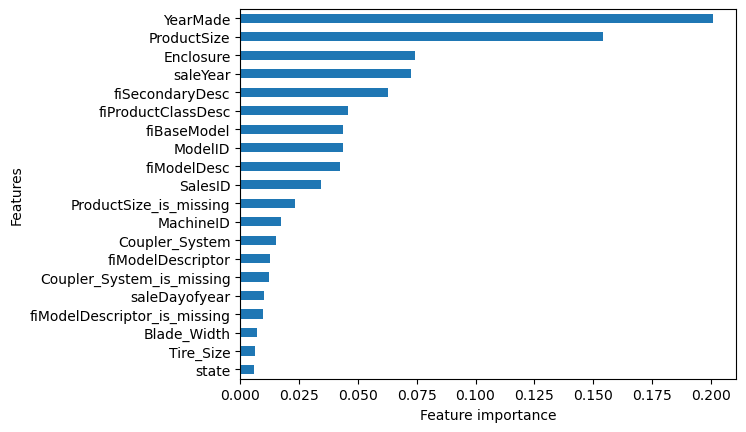

In [150]:
features_df[:20].plot.barh(legend=False)
plt.xlabel("Feature importance")
plt.ylabel("Features");
plt.gca().invert_yaxis();

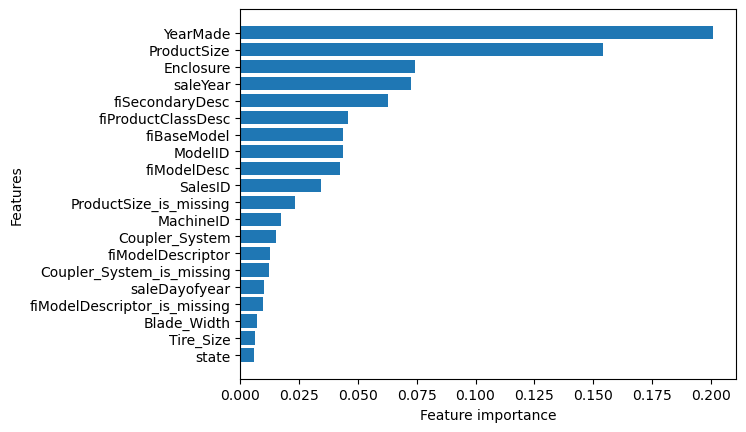

In [151]:
# Using object oriented method
fig, ax = plt.subplots()
ax.barh(features_df.index[:20], features_df["feature_importance"][:20]) # ax.barh(index, values)
ax.set_ylabel("Features")
ax.set_xlabel("Feature importance")
ax.invert_yaxis()

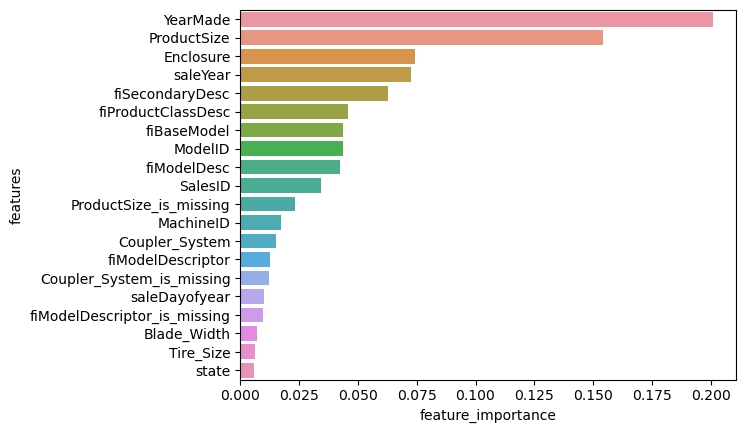

In [154]:
import seaborn as sns
sns.barplot(x="feature_importance", y='features', data=features_df[:20], orient="h");

In [61]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

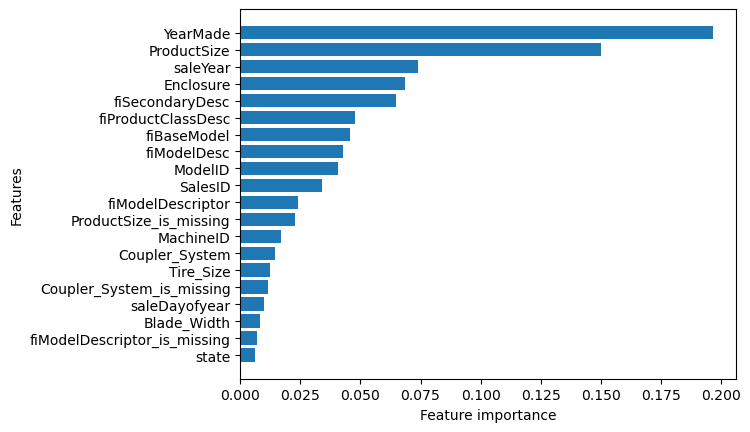

In [35]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [62]:
import seaborn as sns

# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

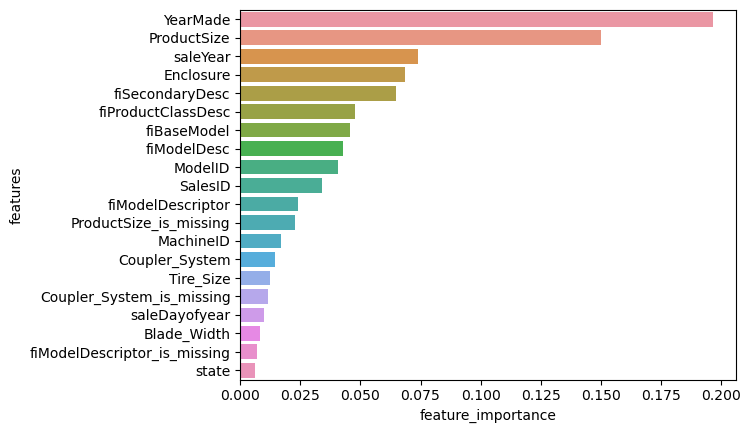

In [38]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [44]:
df["ProductSize"].value_counts()

Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: ProductSize, dtype: int64

In [45]:
df.ProductSize.isna().sum()

216605

In [42]:
df.Turbocharged.value_counts()

None or Unspecified    77111
Yes                     3985
Name: Turbocharged, dtype: int64

In [43]:
df.Thumb.value_counts()

None or Unspecified    85074
Manual                  9678
Hydraulic               7580
Name: Thumb, dtype: int64

In [49]:
import pickle
# Save an existing model to file
pickle.dump(ideal_model, open('data/bluebook-for-bulldozers/bulldozer_price_model_1.pkl', 'wb'))

In [2]:
import pickle
ideal_model = pickle.load(open('data/bluebook-for-bulldozers/bulldozer_price_model_1.pkl', 'rb'))